<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Enhancing Data Science Outcomes With Efficient Workflow #

## 02 - Accelerated Model Development ##
This lab covers the machine learning model development step of the data science workflow. Model development involves model building, evaluation, fine-tuning, model selection, and model persistence. 

<p><img src='images/pipeline_overview_2.png' width=1080></p>

**Table of Contents**
<br>
In this notebook, we will train machine learning models using the Random Forest and XGBoost algorithms. This notebook covers the below sections: 
1. [cuML and Dask-cuML for Accelerated Machine Learning Algorithms](#s2-1)
2. [cuML Random Forest on a Single GPU](#s2-2)
    * [Exercise #1 - Model Performance](#s2-e1)
    * [Data Size vs. Model Performance](#s2-2.1)
    * [Dask-cuML Random Forest on Multi-GPU](#s2-2.2)
3. [XGBoost](#s2-3)
    * [XGBoost on a Single GPU](#s2-3.1)
    * [XGBoost on GPU Cluster with Dask](#s2-3.2)
    * [Exercise #2 - Experimentation](#s2-e2)
    * [Save Model](#s2-3.3)
4. [Feature Importances](#s2-4)

<a name='s2-1'></a>
## cuML and Dask for GPU-Accelerated Machine Learning Algorithms ##
Machine learning requires processing large amounts of data to extra patterns. In fact, machine learning generally works better with more data. Beyond data manipulation, RAPIDS provides a streamlined approach to solve data science problems end to end. It parallelizes compute to multiple cores in the GPU to achieve improved performance over traditional data processing tools. Once data has been loaded on the GPU, we can use cuML to train machine learning models using a `fit`-`transform`-`predict`-style API and Dask-cuML to distribute our computation across a GPU cluster. 

**cuML** [[doc]](https://docs.rapids.ai/api/cuml/stable/]) is a suite of fast, GPU-accelerated machine learning algorithms designed for data science and analytical tasks. cuML provides a scikit-learn-like API that is familiar to data scientists and machine learning engineers. This enables them to accelerate model development without going into the details of CUDA programming. With cuML, we can train machine learning models more efficiently, therefore allowing for more exploration and experimentation to improve model performance. 

As we previously mentioned, [Dask](https://www.dask.org/) is a parallel computing library built on Python. It allows easy management of distributed workers and excels at handling large, distributed data science workflows. Increasingly, machine learning tasks must process massive amounts of data and require the processing to be distributed across multiple GPUs. Dask-cuML enables scalable distributed training on a GPU cluster. 

Using Dask with GPU-based machine learning can help us scale in several dimensions: 
1. When the challenge is computing bound, GPU-accelerated machine learning algorithms can speed up computationally intensive workflows
2. When the challenge is memory bound, Dask offers the ability to work with larger datasets and thereby improving the performance and resilience of models

<p><img src='images/tip.png' width=720></p>

When the dataset is small, we don't expect to observe cuML performance to be faster than scikit-learn. In many cases, performance advantages appear as the dataset grows. A modern GPU can have thousands of cores. To realize the benefits of acceleration, we can maximize performance by providing enough data to keep the hardware busy. 

<a name='s2-2'></a>
## cuML Random Forest on a Single GPU ##
cuML has a GPU-accelerated `cuml.ensemble.RandomForestClassifier()`[[doc]](https://docs.rapids.ai/api/cuml/stable/api.html#random-forest) algorithm. The cuML Random Forest model uses a high-performance **quantiles** split algorithm when building the trees. The quantiles split algorithm precomputes the potential split values for each feature one time per tree at the root node. Each feature column is sorted in ascending order and split into bins such that each bin contains an equal portion of the root node’s dataset. The end range of each bin is considered as a potential split value. 

There are a number of [parameters](https://docs.rapids.ai/api/cuml/stable/api.html#cuml.ensemble.RandomForestClassifier) that can be tuned related to `split_criterion`, `samples`, `depth`, `features`, and `n_bins`. 

In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

from cuml.model_selection import train_test_split
from cuml.ensemble import RandomForestClassifier as cumlRF
from cuml.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, classification_report, f1_score

import dask_cudf
import cudf
import numpy as np
import matplotlib.pyplot as plt
import time
import gc

In [2]:
# initialize features list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday', 
               'brand_target_sum', 'brand_count', 'cat_0_target_sum', 
               'cat_0_count', 'cat_1_target_sum', 'cat_1_count', 
               'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 
               'cat_3_count', 'TE_brand_target', 'TE_cat_0_target', 
               'TE_cat_1_target', 'TE_cat_2_target', 'TE_cat_3_target', 
               'relative_price_product', 'relative_price_category']

include=features_list+['target']

We start by importing data. Since we are training with a single GPU, we will load the data input the memory with `.compute()`. Data needs to be split into a train and test set, which can be accomplished with `cuml.model_selection.train_test_split()`[[doc]](https://docs.rapids.ai/api/cuml/stable/api.html#model-selection-and-data-splitting). 

In [3]:
# load data
parquet_dir='processed_parquet'

ddf=dask_cudf.read_parquet(parquet_dir, columns=include)
gdf=ddf.compute()

print(f'Total of {len(gdf)} records. ')

Total of 2461697 records. 


In [4]:
# define features and target
y=gdf['target']
X=gdf[features_list]

# split data into train and test sett
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

<p><img src='images/tip.png' width=720></p>


Recall that Dask-cuDF is the recommended way of loading large datasets. 

Next, we will train the model. We are using the default model parameters and 100 for `n_estimators` to compare the training times between cuML and scikit-learn. 

In [5]:
# set estimator parameters
rf_params={
    'n_estimators': 100, 
}

# initialize estimator with key parameters
rf=cumlRF(**rf_params)

In [6]:
# fit estimator
start=time.time()
rf.fit(X_train, y_train)
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

Training 1846272 samples took 0.29 minutes. 


<a name='s2-e1'></a>
### Exercise #1 - Performance Model Evaluation ###

We can use the `cuml.metrics.precision_recall_curve()`[[doc]](https://docs.rapids.ai/api/cuml/stable/api/#cuml.metrics.precision_recall_curve) and `cuml.metrics.roc_auc_score()`[[doc]](https://docs.rapids.ai/api/cuml/stable/api/#cuml.metrics.roc_auc_score) functions to calculate the model performance. Alternatively, we can check the overall performance of the model with `cuml.metrics.accuracy.accuracy_score()`[[doc]](https://docs.rapids.ai/api/cuml/stable/api.html#metrics-regression-classification-and-distance). 

**Instructions**: <br>
* Modify the `<FIXME>`s only and execute the below cell to calculate the precision, recall, and AUC ROC scores. 

In [12]:
# perform model evaluation
prediction_test=rf.predict_proba(X_test)[1]

precision, recall, thresholds=precision_recall_curve(y_test, prediction_test)
auc_roc=roc_auc_score(y_test, prediction_test)

print(f'Area Under the Receiver Operating Characteristic Curve is {round(auc_roc, 2)}. ')

Area Under the Receiver Operating Characteristic Curve is 0.63. 


Click ... to show **solution**.

<p><img src='images/tip.png' width=720></p>

Using `metrics` from cuML requires CuPy arrays. The scikit-learn equivalent can be used when the outputs are moved to the host. 

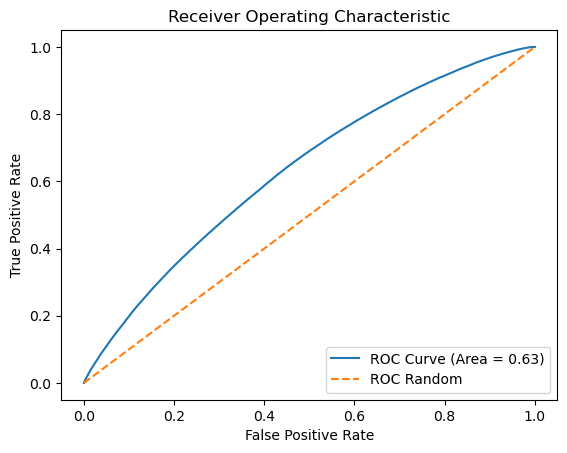

In [13]:
# calculate fpr and tpr using sklearn
prediction_test_numpy=prediction_test.to_numpy()
y_test_numpy=y_test.to_numpy()
fpr, tpr, _=roc_curve(y_test_numpy, prediction_test_numpy)

# plot ROC
plt.plot(fpr, tpr, label=f'ROC Curve (Area = {round(auc_roc, 2)})')
plt.plot([0, 1], [0, 1], linestyle='--', label='ROC Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [14]:
# calculate classification report using sklearn
best_threshold=.5

# get prediction label if using best threshold
prediction_label_numpy=(prediction_test >= best_threshold).astype('int64').to_numpy()

# calculate F1 score
f1=f1_score(y_test_numpy, prediction_label_numpy)
print(f'F1 Score is {round(f1, 2)}. ')

# generate classification report and confusion matrix
print("Classification Report: \n", classification_report(y_test_numpy, prediction_label_numpy))
print("Confusion Matrix: \n", confusion_matrix(y_test_numpy, prediction_label_numpy))

F1 Score is 0.37. 
Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.85      0.72    362341
           1       0.56      0.28      0.37    253084

    accuracy                           0.61    615425
   macro avg       0.60      0.56      0.55    615425
weighted avg       0.60      0.61      0.58    615425

Confusion Matrix: 
 [[307197  55144]
 [182061  71023]]


<a name='s2-2.1'></a>
### Mode Size vs. Model Performance ###
Model performance generally improves as the size of the training dataset grows. Increasing the number of trees can also improve model performance. cuML speeds up machine learning training and enables more experimentation. We will train several models to see the effects of data size and `n_estimators`. 

In [15]:
# define model to train random forest classifier
def train(frac, n_estimators): 
    
    gdf_sample=gdf.sample(frac=frac)
    X=gdf_sample[features_list]
    y=gdf_sample['target']
    X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
    
    rf=cumlRF(n_estimators=n_estimators)
    
    # time training
    start=time.time()
    rf.fit(X_train, y_train)
    elapsed_time=time.time()-start
    
    # calculate auc roc
    prediction_test=rf.predict_proba(X_test)[1]
    auc_roc=roc_auc_score(y_test, prediction_test)
    
    return elapsed_time, auc_roc, len(X_train)

In [16]:
# create lists to contain experiment statistics
auc_roc_scores=[]
model_sizes=[]
times=[]

for n_estimators in range(50, 451, 100): 
    elapsed_time, auc_roc, sample_size=train(1, n_estimators)
    
    times.append(elapsed_time)
    auc_roc_scores.append(auc_roc)
    model_sizes.append(n_estimators)
    
    print(f'Training {n_estimators} trees yielded {round(auc_roc*100, 2)}% AUC and took {round(elapsed_time/60, 2)} minutes. ')

Training 50 trees yielded 63.17% AUC and took 0.12 minutes. 
Training 150 trees yielded 63.34% AUC and took 0.35 minutes. 
Training 250 trees yielded 63.4% AUC and took 0.59 minutes. 
Training 350 trees yielded 63.45% AUC and took 0.83 minutes. 
Training 450 trees yielded 63.29% AUC and took 1.06 minutes. 


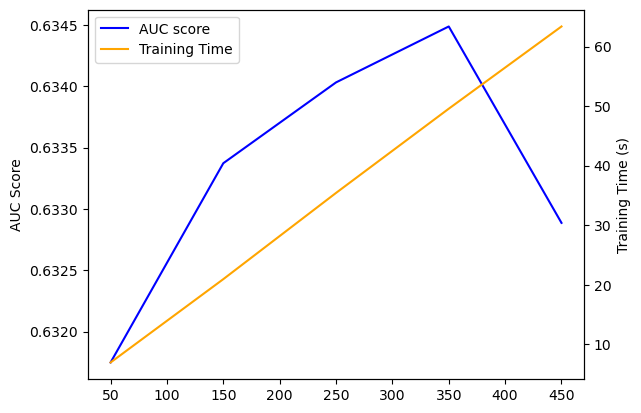

In [17]:
# plot auc roc vs. model size
fig, axes=plt.subplots()

ln_1=axes.plot(model_sizes, auc_roc_scores, label='AUC score', color='blue')
axes.set_ylabel('AUC Score')

axes_right=axes.twinx()
ln_2=axes_right.plot(model_sizes, times, label='Training Time', color='orange')
axes_right.set_ylabel('Training Time (s)')

axes.legend(ln_1+ln_2, [ln.get_label() for ln in ln_1+ln_2])

plt.xlabel('Training Size')
plt.ticklabel_format(style='plain')
plt.show()

In [18]:
# create lists to contain experiment statistics
auc_roc_scores=[]
sample_sizes=[]
times=[]

for frac in np.arange(0.2, 1.1, 0.2): 
    n_estimators=350
    elapsed_time, auc_roc, sample_size=train(frac, n_estimators=n_estimators)
    
    times.append(elapsed_time)
    auc_roc_scores.append(auc_roc)
    sample_sizes.append(sample_size)
    
    print(f'Training {sample_size} samples with {n_estimators} trees yielded {round(auc_roc*100, 2)}% AUC and took {round(elapsed_time/60, 2)} minutes. ')

Training 369254 samples with 350 trees yielded 62.19% AUC and took 0.11 minutes. 
Training 738509 samples with 350 trees yielded 62.7% AUC and took 0.27 minutes. 
Training 1107763 samples with 350 trees yielded 63.03% AUC and took 0.45 minutes. 
Training 1477018 samples with 350 trees yielded 63.17% AUC and took 0.64 minutes. 
Training 1846272 samples with 350 trees yielded 63.34% AUC and took 0.83 minutes. 


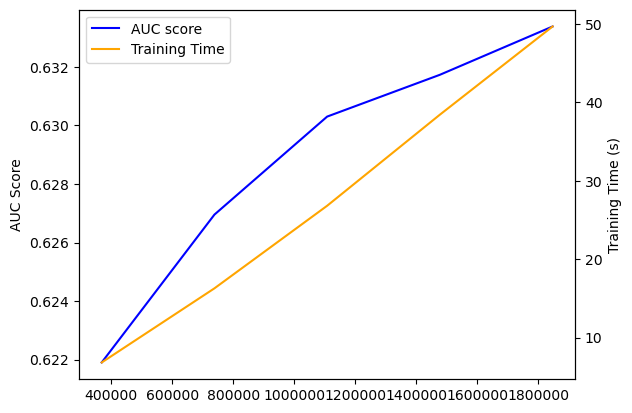

In [19]:
# plot auc roc vs. sample size
fig, axes=plt.subplots()

ln_1=axes.plot(sample_sizes, auc_roc_scores, label='AUC score', color='blue')
axes.set_ylabel('AUC Score')

axes_right=axes.twinx()
ln_2=axes_right.plot(sample_sizes, times, label='Training Time', color='orange')
axes_right.set_ylabel('Training Time (s)')

axes.legend(ln_1+ln_2, [ln.get_label() for ln in ln_1+ln_2])

plt.xlabel('Training Size')
plt.ticklabel_format(style='plain')
plt.show()

As the size of data and model increase, the model performance tends to better. Importantly, the amount of time it takes for cuML to train the model is approximately linear. 

In [20]:
# clean up
del gdf, X, y, ddf, rf, X_train, X_test, y_train, y_test
gc.collect()

12017

<a name='s2-2.2'></a>
### Dask-cuML Random Forest on Multi-GPU ###
To accelerate this process, cuML can construct trees in parallel across multiple GPUs across a cluster using [Dask](https://www.dask.org/). 

Dask can be used to scale cuML's Random Forest classifier in two ways: 
1. Data can be randomly split and shared equally across all workers, in which case each worker builds trees on a subset of the full data. In other words, For a forest with `N` trees being built on `w` workers, each worker simply builds `N/w` trees on a subset of the total dataset it has available locally. This requires partitioning the data in a well-shuffled, balanced way in advance. This random sharing approach effectively expands the amount of available memory and typically works well. With this approach, both the dataset and trees are distributed across multiple GPUs, leading to better than linear speedup scaling across multiple devices. There could be some small differences in terms of accuracy between single-GPU and multi-GPU runs, which is to be expected given the different data distributions. 
2. Training data can be replicated so that each worker receives `w` partitions when `.fit()` is called. This will give all workers a complete view of the dataset. This would produce results approximately identical to single-GPU fitting.

The random sharing approach effectively expands the amount of available memory and typically works well but requires careful data splitting and model tuning to achieve good results. We will distribute and split data into each GPU worker and train several trees in parallel. 

By default, Dask will only use a single GPU. To use multiple GPUs, users will want to either use the `dask_cuda.LocalCUDACluster()`[[doc]](https://docs.rapids.ai/api/dask-cuda/stable/api.html) API or launch Dask workers from the command line (one per GPU). We will also initialize a `dask.distributed.Client` and point it to the cluster. The Dask client connects to and submits computations to a Dask cluster. 

In [21]:
# import dependencies
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

# instantiate a Client
cluster=LocalCUDACluster()
client=Client(cluster)

2023-12-11 16:38:01,239 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:38:01,239 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-11 16:38:01,333 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:38:01,333 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-11 16:38:01,386 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:38:01,386 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-11 16:38:01,436 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:38:01,437 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [22]:
# get the machine's external IP address
from requests import get

ip=get('https://api.ipify.org').content.decode('utf8')

print(f'Dask dashboard (status) is accessible on http://{ip}:8787/status')
print(f'Dask dashboard (gpu) is accessible on http://{ip}:8787/gpu')

Dask dashboard (status) is accessible on http://3.236.6.127:8787/status
Dask dashboard (gpu) is accessible on http://3.236.6.127:8787/gpu


cuML nicely integrates with Dask to make training a models easy across multiple GPUs. cuML has a `cuml.dask.ensemble.RandomForestClassifier`[[doc]](https://docs.rapids.ai/api/cuml/stable/api.html#id47) algorithm. We build a classification model to predict the binary outcome. Other multi-node, multi-GPU algorithms can be found in the [documentation](https://docs.rapids.ai/api/cuml/stable/api.html#multi-node-multi-gpu-algorithms). 

In [23]:
# import dependencies
from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF

from dask_ml.model_selection import train_test_split
from dask_ml.metrics import accuracy_score

In [24]:
# initialize features list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday', 
               'brand_target_sum', 'brand_count', 'cat_0_target_sum', 
               'cat_0_count', 'cat_1_target_sum', 'cat_1_count', 
               'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 
               'cat_3_count', 'TE_brand_target', 'TE_cat_0_target', 
               'TE_cat_1_target', 'TE_cat_2_target', 'TE_cat_3_target', 
               'relative_price_product', 'relative_price_category']

include=features_list+['target']

We start by importing data. Except for creating the cluster with multiple-GPUs, the code for importing data will be similar. Data needs to be split into a train and validation set, which can be accomplished with `dask_ml.model_selection.train_test_split()`[[doc]](https://ml.dask.org/modules/generated/dask_ml.model_selection.train_test_split.html). When fitting the model, data is expected to be partitioned with at least one partition on each Dask worker being used. If a worker has multiple data partitions, they will be concatenated before fitting, which will lead to additional memory usage. To minimize memory consumption, ensure that each worker has exactly one partition. When persisting data, we can use `cuml.dask.common.utils.persist_across_workers()` or `.persist()` with the data and workers. When using the latter approach, both `X` and `y` should be persisted across workers. 

In [25]:
# load data
parquet_dir='processed_parquet'
ddf=dask_cudf.read_parquet(parquet_dir, columns=include)

print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 2461697 records split across 4 partitions. 


In [26]:
y=ddf['target'].astype('int32') # Dask RF requires data to be int32
X=ddf[features_list].astype('float32') # Dask RF requires data to be float32

# split data into train and validation
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

# distributing the data evenly across all the workers
X_train, X_test, y_train, y_test=client.persist([X_train, X_test, y_train, y_test])
wait([X_train, X_test, y_train, y_test])

DoneAndNotDoneFutures(done={<Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-6fc6441ba788d6759d150fe9ffb3223f', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-6fc6441ba788d6759d150fe9ffb3223f', 0)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-a2e1e21591b95809d6ce3899f0dcf234', 0)>, <Future: finished, type: cudf.core.series.Series, key: ('split-1-a2e1e21591b95809d6ce3899f0dcf234', 3)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-6fc6441ba788d6759d150fe9ffb3223f', 2)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-a2e1e21591b95809d6ce3899f0dcf234', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-6fc6441ba788d6759d150fe9ffb3223f', 3)>, <Future: finished, type: cudf.core.series.Series, key: ('split-1-a2e1e21591b95809d6ce3899f0dcf234', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-6fc6441ba788d6759d150fe9ffb3223f', 0)

Next, we train the model. 

In [27]:
# cuML Random Forest params
dask_rf_params={
    'n_estimators': 150,
    'n_streams': 1, 
    'ignore_empty_partitions': True, 
}

dask_rf=cumlDaskRF(**dask_rf_params)

start=time.time()
dask_rf.fit(X_train, y_train)
wait(dask_rf.rfs) # allow asynchronous training tasks to finish
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

Training 2216183 samples took 0.03 minutes. 


<p><img src='images/tip.png' width=720></p>

<p><img src='images/rf_train.png' width=720></p>

When we examine the Dask Diagnostics Dashboard, we see that the `.fit()` executed quickly (left). Had we broadcast all data to all workers, we would have seen Task Streams that include transfers (right). This could be computationally intensive and take longer to train, depending on the size of the dataset. 

Lastly, we evaluate the model performance. At inference time, predictions from trees on all of the workers are combined, just as if the trees had all been trained on a single GPU. We can check the performance of the estimator with `dask_ml.metrics.accuracy_score()`[[doc]](https://ml.dask.org/modules/generated/dask_ml.metrics.accuracy_score.html). 

In [28]:
# due to randomness in the algorithm, we may see slight variation in accuracies
start=time.time()
prediction_test=dask_rf.predict(X_test)
elapsed_time=time.time()-start

print(f'Accuracy score for test set: {round(float(accuracy_score(y_test, prediction_test>0.5))*100, 2)}%')

throughput=round(len(X_test)/elapsed_time, 2)
print(f'Throughput is: {throughput} per seconds. ')

Accuracy score for test set: 61.38%
Throughput is: 59773.25 per seconds. 


In [29]:
# clean GPU memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}

<a name='s2-3'></a>
## XGBoost ##
Random Forest uses a bagging technique to train independent trees for the ensemble model. Another popular decision tree ensemble uses the gradient boosting algorithm, which trains decision tree models sequentially that address weaknesses from previous trees. The idea of boosting means the algorithm combines weak learners into a stronger one in an iterative fashion. It has gained popularity because it produces high accuracy while being fast on large datasets. 

<p><img src='images/XGBoost.png' width=720></p>

The popular **XGBoost** [[doc]](https://xgboost.readthedocs.io/en/stable/) is an optimized distributed gradient boosting library. 
More information about XGBoost can be found in [this article](https://www.nvidia.com/en-us/glossary/data-science/xgboost/). Accelerating and scaling XGBoost GPU training is easy with the native support of Dask. With both libraries having integration with cuDF, we can even scale up the whole data processing pipeline. 

<a name='s2-3.1'></a>
### XGBoost on a Single GPU ###
XGBoost can be used to train models for regression or classification. We use the loss function and `objective` parameter to define the task. The loss function can be configured to include [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)). The regularization term controls the complexity of the model, which can help us avoid overfitting. As with other machine learning models, tuning an XGBoost model often involves balancing the bias-variance tradeoff in machine learning. 

XGBoost refers to the model as a [Booster](https://xgboost.readthedocs.io/en/stable/tutorials/model.html#introduction-to-boosted-trees). 
XGBoost can be accelerated with CUDA-capable GPUs by specifying the `tree_method` parameter as `gpu_hist`. Detail about GPU support for XGBoost can be found [here](https://xgboost.readthedocs.io/en/stable/gpu/index.html). 

XGBoost provides two sets of APIs. One is functional and the other is modeled after the scikit-learn interface. We will demonstrate both: 
* The functional API one uses `xgboost.train()` and `DMatrix` 
* Another set of API uses an `XGBClassifier`

XGBoost has several model parameters: 
* General - the type of booster, which could be `tree model` or `linear model`. We will use the `tree model`
* Booster - parameters related to the chosen booster. We will use some booster parameters related to Tree Boosters to overcome overfitting
    * The following parameters adjust model complexity: 
        * `max_depth` (default=6) - maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit 
        * `min_child_weight` (default=1) - minimum sum of instance weight needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than `min_child_weight`, then the building process will give up further partitioning. The larger `min_child_weight` is, the more conservative the model will be
        * `min_split_loss` or `gamma` (default=0) - the minimum loss reduction required to make a further partition on a leaf node of the tree. The larger `gamma` or `min_split_loss` is, the more conservative the model will be
    * The following parameters increase the randomness of the model so it can generalize better: 
        * `subsample` (default=1) - subsample ratio of the training instances. Setting `subsample` to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees
        * `colsample_bytree` (default=1) - subsample ratio of columns when constructing each tree
        * `eta` or `learning_rate` (default=0.3) - step-size shrinkage used in update to prevent overfitting. `eta` shrinks the feature weights to make the boosting process more conservative
* Learning Task - parameters related to the learning scenario
    * `objective` (default=reg:squarederror) - various learning objectives. We use `binary:logisitc` for a binary classification task to output probabilities. The full list of `objective` options can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html#xgboost-parameters)

More details about the parameters of XGBoost can be found [here](https://xgboost.readthedocs.io/en/stable/parameter.html#xgboost-parameters). 

<p><img src='images/tip.png' width=720></p>

Parameters such as `max_depth` can cause XGBoost to consume more memory when training. 

In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')

import xgboost
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score

import matplotlib.pyplot as plt
import dask_cudf
import time
import gc

We start by importing data. Since we are training with a single GPU, we will load the data input the memory with `.compute()`. Data needs to be split into a train and test set, which can be accomplished with `cuml.model_selection.train_test_split()`[[doc]](https://docs.rapids.ai/api/cuml/stable/api.html#model-selection-and-data-splitting). 

In [2]:
# initializing list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday', 
               'brand_target_sum', 'brand_count', 'cat_0_target_sum', 
               'cat_0_count', 'cat_1_target_sum', 'cat_1_count', 
               'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 
               'cat_3_count', 'TE_brand_target', 'TE_cat_0_target', 
               'TE_cat_1_target', 'TE_cat_2_target', 'TE_cat_3_target', 
               'relative_price_product', 'relative_price_category']
         
include=features_list+['target']

In [3]:
# load data with dask_cudf
parquet_dir='processed_parquet'
ddf=dask_cudf.read_parquet(parquet_dir, columns=include)

# load data into single GPU memory
gdf=ddf.compute()

print(f'Total of {len(gdf)} records. ')

Total of 2461697 records. 


In [4]:
# XGBoost treats all data as 32-bit float internally or we can explicitly convert
y=gdf['target'].astype('float32')
X=gdf[features_list].astype('float32')

# split data into train and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)

[DMatrix](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix) is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. XGBoost supports building a DMatrix from a cuDF DataFrame that's already on the GPU without the need to first copy data to CPU memory. This significantly reduces overhead for the overall development workflow. 

In [5]:
# create DMatrix
dtrain=xgboost.DMatrix(X_train, y_train) 
dtest=xgboost.DMatrix(X_test, y_test)

Next, we will fit the model. XGBoost enables early stopping through the `early_stopping_rounds` parameter and custom objective as well as evaluation metrics. Early stopping will force XGBoost to stop the training process once the validation metric fails to improve after a specific number of consecutive rounds. XGBoost provides two sets of APIs: 
1. Uses `xgboost.train()`
2. Uses `XGBClassifier`

When training with `xgboost.train()`, we need to create an empty dictionary and pass it to the `evals_result` parameter if we want to save the training history. 

In [6]:
# train XGBoost classification model on single GPU
# define model parameter
xgb_params={ 
    'eval_metric': ['auc'], 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist'
}

evaluation_result={}

# train the model
start=time.time()
xgb_clf=xgboost.train(xgb_params, 
                   dtrain=dtrain,
                   evals=[(dtrain, 'train'), (dtest, 'valid')],
                   num_boost_round=350,
                   early_stopping_rounds=5, 
                   evals_result=evaluation_result
)
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

[0]	train-auc:0.60701	valid-auc:0.60556
[1]	train-auc:0.60901	valid-auc:0.60759
[2]	train-auc:0.61019	valid-auc:0.60897
[3]	train-auc:0.61117	valid-auc:0.60972
[4]	train-auc:0.61185	valid-auc:0.61031
[5]	train-auc:0.61249	valid-auc:0.61095
[6]	train-auc:0.61309	valid-auc:0.61148
[7]	train-auc:0.61374	valid-auc:0.61205
[8]	train-auc:0.61446	valid-auc:0.61264
[9]	train-auc:0.61537	valid-auc:0.61345
[10]	train-auc:0.61571	valid-auc:0.61367
[11]	train-auc:0.61627	valid-auc:0.61419
[12]	train-auc:0.61659	valid-auc:0.61443
[13]	train-auc:0.61700	valid-auc:0.61475
[14]	train-auc:0.61725	valid-auc:0.61489
[15]	train-auc:0.61793	valid-auc:0.61543
[16]	train-auc:0.61815	valid-auc:0.61551
[17]	train-auc:0.61860	valid-auc:0.61588
[18]	train-auc:0.61888	valid-auc:0.61605
[19]	train-auc:0.61911	valid-auc:0.61611
[20]	train-auc:0.61933	valid-auc:0.61623
[21]	train-auc:0.61952	valid-auc:0.61634
[22]	train-auc:0.61978	valid-auc:0.61647
[23]	train-auc:0.62005	valid-auc:0.61656
[24]	train-auc:0.62017	val

There is another interface that mimics scikit-learn estimators with higher level of abstraction. It might be easier to use compared to the functional interface but also has more constraints. 

In [7]:
# use XGBClassifier
# define model parameter
xgb_params={
    'n_estimators': 350, 
    'tree_method': 'gpu_hist', 
    'early_stopping_rounds': 10, 
    'eval_metric': ['auc'], 
    'objective': 'binary:logistic'
}

xgb_clf=xgboost.XGBClassifier(**xgb_params)

# train the model
start=time.time()
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

Training 1846272 samples took 0.09 minutes. 


Finally, we evaluate the model performance. 

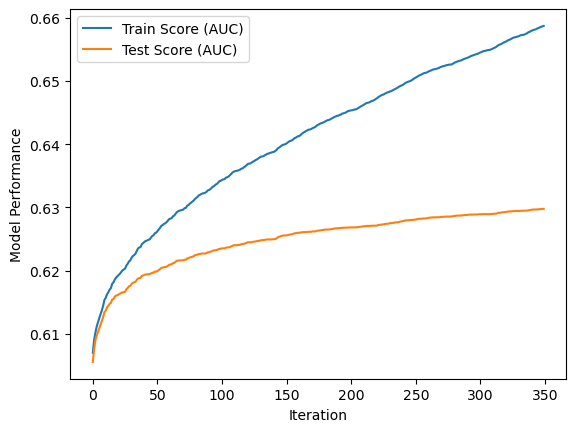

In [8]:
# plot training result
plt.plot(evaluation_result['train']['auc'], label='Train Score (AUC)')
plt.plot(evaluation_result['valid']['auc'], label='Test Score (AUC)')

plt.xlabel('Iteration')
plt.ylabel('Model Performance')
plt.legend()
plt.show()

In [9]:
# clean up
del gdf, X, y, X_train, X_test, y_train, y_test, dtrain, dtest, xgb_clf
gc.collect()

4109

<a name='s2-3.2'></a>
### XGBoost on GPU Cluster with Dask ###
By default, XGBoost trains models sequentially. This is fine if the dataset is small, but as the size of dataset or model grows, we will want to consider running XGBoost in distributed mode with Dask to speed up computations and reduce the memory burden on the GPU. XGBoost relies on CUDA and Dask to provide an efficient distributed training solution over multiple GPUs. 

During distributed training, XGBoost trains a model with a subset of data on each worker. When data is loaded with Dask-cuDF, the subsets are cuDF DataFrame partitions scatter across individual GPU workers. The histogram of gradients for each tree node is synched across workers. 

<p><img src='images/xgboost_dask.png' width=720></p>

By default, Dask will only use a single GPU. To use multiple GPUs, users will want to either use the `dask_cuda.LocalCUDACluster()`[[doc]](https://docs.rapids.ai/api/dask-cuda/stable/api.html) API or launch Dask workers from the command line (one per GPU). We will initialize a `dask.distributed.Client` by pointing it to the address of the cluster scheduler. The Dask client connects to and submits computations to a Dask cluster. 

When using XGBoost with Dask, we need to call the `xgboost.dask` interface from the client side. The main difference with XGBoost’s Dask interface is that we pass our Dask client as an additional argument for carrying out the computation. Note that if the client parameter below is set to `None`, XGBoost will use the default client returned by Dask.

In [10]:
# import dependencies
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

# instantiate a Client
cluster=LocalCUDACluster()
client=Client(cluster)

2023-12-11 16:58:39,456 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:58:39,456 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-11 16:58:39,468 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:58:39,468 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-11 16:58:39,518 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:58:39,518 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-12-11 16:58:39,573 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-12-11 16:58:39,573 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [11]:
# get the machine's external IP address
from requests import get

ip=get('https://api.ipify.org').content.decode('utf8')

print(f'Dask dashboard (status) is accessible on http://{ip}:8787/status')
print(f'Dask dashboard (gpu) is accessible on http://{ip}:8787/gpu')

Dask dashboard (status) is accessible on http://3.236.6.127:8787/status
Dask dashboard (gpu) is accessible on http://3.236.6.127:8787/gpu


In [12]:
# import dependencies
from dask_ml.model_selection import train_test_split
from dask_ml.metrics import accuracy_score

We start by loading the data into GPUs. After data loading, we prepare the training and testing splits. We use Dask-cuDF for loading data from the disk, and the `dask_ml.model_selection.train_test_split()`[[doc]](https://ml.dask.org/modules/generated/dask_ml.model_selection.train_test_split.html) function from [Dask-ML](https://ml.dask.org/) for splitting up the dataset. The GPU backend of Dask works seamlessly with utilities in Dask-ML so the entire machine learning pipeline can be accelerated. 

<p><img src='images/tip.png' width=720></p>

Even using Dask Dataframes, XGBoost executes completely in memory, meaning we can’t spill as dynamically from GPU to host memory. The total amount of RAM needed on the cluster is directly proportional to the total size of the training dataset. Users should expect large amounts of unmanaged memory during the training phase, consumed by the heap of the training tasks. This heap memory requirements are directly proportional to total dataset size / number of workers. This is unlike most other Dask workflows, where heap size is proportional to partition size * threads per worker.

In [13]:
# initializing list
features_list=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 
               'price', 'ts_hour', 'ts_minute', 'ts_weekday', 
               'brand_target_sum', 'brand_count', 'cat_0_target_sum', 
               'cat_0_count', 'cat_1_target_sum', 'cat_1_count', 
               'cat_2_target_sum', 'cat_2_count', 'cat_3_target_sum', 
               'cat_3_count', 'TE_brand_target', 'TE_cat_0_target', 
               'TE_cat_1_target', 'TE_cat_2_target', 'TE_cat_3_target', 
               'relative_price_product', 'relative_price_category']
         
include=features_list+['target']

In [14]:
# import data
parquet_dir='processed_parquet'
ddf=dask_cudf.read_parquet(parquet_dir, columns=include)

print(f'Total of {len(ddf)} records split across {ddf.npartitions} partitions. ')

Total of 2461697 records split across 4 partitions. 


In [15]:
# XGBoost treats all data as 32-bit float internally
y=ddf['target'].astype('float32')
X=ddf[features_list].astype('float32')

In [16]:
# split data into train and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
X_train, X_test, y_train, y_test=client.persist([X_train, X_test, y_train, y_test])
wait([X_train, X_test, y_train, y_test])

DoneAndNotDoneFutures(done={<Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-98f532052c3598684cd333c4f178b393', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-98f532052c3598684cd333c4f178b393', 2)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-98f532052c3598684cd333c4f178b393', 0)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-b4d0d9fe1dd95244710464fc7a6567ba', 3)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-b4d0d9fe1dd95244710464fc7a6567ba', 1)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-1-98f532052c3598684cd333c4f178b393', 2)>, <Future: finished, type: cudf.core.series.Series, key: ('split-1-b4d0d9fe1dd95244710464fc7a6567ba', 2)>, <Future: finished, type: cudf.core.series.Series, key: ('split-0-b4d0d9fe1dd95244710464fc7a6567ba', 0)>, <Future: finished, type: cudf.core.dataframe.DataFrame, key: ('split-0-98f532052c3598684cd333c4f178b393', 0)

We then create an `xgboost.dask.DaskMatrix`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.dask.DaskDMatrix) object and pass it to `xgboost.dask.train()`, along with some other parameters, much like XGBoost's normal, non-Dask interface. We have to pass a Dask DataFrame or Dask Array to the `data` and `label` parameters. Importantly, we have to pass the Dask client as an additional argument for carrying out the computation. If we don't pass a client, `xgboost.dask.train()` will use a default client returned by Dask. 

The `xgboost.dask.DaskDMatrix` acts like a normal DMatrix and works as a proxy for local DMatrix scattered around the workers. The `DaskDMatrix` constructor forces computation that scatters DMatrix around the workers, which means it's where all earlier computations are actually being carried out, including operations like `.read_csv()`. To isolate the computation in DaskDMatrix from other lazy computations, we can explicitly wait for results of input data before constructing a `DaskDMatrix`. 

In [17]:
# create DMatrix
dtrain=xgboost.dask.DaskDMatrix(client, X_train, y_train)
dtest=xgboost.dask.DaskDMatrix(client, X_test, y_test)

Next, we fit the model. We can implement more advanced early stopping strategies, which are implemented as a [callback](https://xgboost.readthedocs.io/en/stable/python/callbacks.html) function in XGBoost. Furthermore, we can implement custom objectives and evaluation metrics, as described [here](https://xgboost.readthedocs.io/en/stable/tutorials/custom_metric_obj.html). 

<p><img src='images/tip.png' width=720></p>

We evaluate model performance with the popular [Receiver Operating Characteristic Area under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) by using `auc` for `eval_metric`. In a distributed environment, the AUC is calculated as a weighted average over the AUC of training rows on each node. Distributed AUC is an approximation that is sensitive to the distribution of data across workers. It will yield `NaN` when input dataset contains only negative or positive samples (on any node). 

Unlike `xgboost.train()`, which returns a booster, `xgboost.dask.train()` returns a dictionary with the boosters and evaluation results. 

In [18]:
# define model parameters
xgb_params={ 
    'eval_metric': ['auc'], 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist'
}

# train the model
start=time.time()
xgb_dask_clf=xgboost.dask.train(client, 
                        xgb_params, 
                        dtrain=dtrain,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        num_boost_round=350,
                        early_stopping_rounds=10, 
                        verbose_eval=False
)
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

[16:59:25] task [xgboost.dask-0]:tcp://127.0.0.1:45639 got new rank 0
[16:59:25] task [xgboost.dask-1]:tcp://127.0.0.1:42149 got new rank 1
[16:59:25] task [xgboost.dask-2]:tcp://127.0.0.1:36129 got new rank 2
[16:59:25] task [xgboost.dask-3]:tcp://127.0.0.1:43807 got new rank 3


Training 2216183 samples took 0.07 minutes. 


Given the data and a set of parameters, the `xgboost.dask.train()` returns a booster and the computation history as a dictionary: 
```
{'booster': Booster,
 'history': dict}
 ``` 

The Booster returned is the same as the one returned by `xgboost.train()`, which means we can use it to predict or save for later. The `xgboost.Booster`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster) model can be referenced with `output['booster']`. For prediction, we pass the output returned by train into `xgboost.dask.predict()`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.dask.predict) or equivalently `output['booster']`. The usage of `.predict()` is further described [here](https://xgboost.readthedocs.io/en/stable/prediction.html). We can check the performance of the estimator with `dask_ml.metrics.accuracy_score()`[[doc]](https://ml.dask.org/modules/generated/dask_ml.metrics.accuracy_score.html). 

Lastly, we evaluate the model. 

In [19]:
# predict
start=time.time()
prediction_test=xgboost.dask.predict(client, xgb_dask_clf, dtest)
elapsed_time=time.time()-start

print(f'Accuracy score for test set: {round(float(accuracy_score(y_test, prediction_test>0.5))*100, 2)}%')

throughput=round(len(X_test)/elapsed_time, 2)
print(f'Throughput is: {throughput} per seconds. ')

Accuracy score for test set: 61.48%
Throughput is: 1624220.0 per seconds. 


/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a cudf object before performing the operation.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a cudf object before performing the operation.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a 

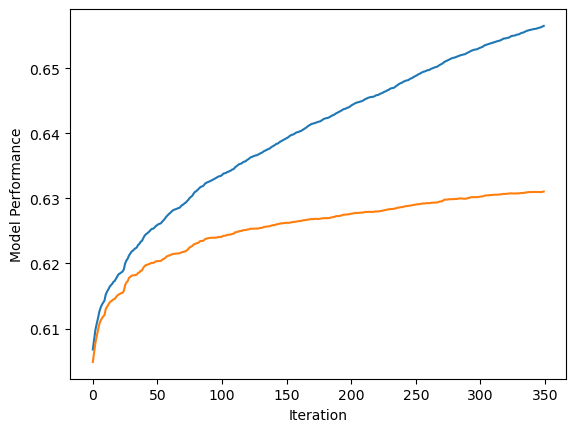

In [20]:
# plot training results
history=xgb_dask_clf['history']

plt.plot(history['train']['auc'], label='Train Score (AUC)')
plt.plot(history['valid']['auc'], label='Test Score (AUC)')

plt.xlabel('Iteration')
plt.ylabel('Model Performance')
plt.show()

<a name='s2-e2'></a>
### Exercise #2 - Experimentation ###

Machine learning requires experimentation to achieve optimal results. There are some model parameters we can use to reduce overfitting. At a high level, they can be categorized as: 
1. Parameters that control model complexity: 
    * `max_depth`, `min_child_weight` and `gamma`
2. Parameters that add randomness to make training robust to noise: 
    * `subsample` and `colsample_bytree`

We can also reduce `eta` (`learning_rate`) or increase `num_round`.

**Instructions**: <br>
* Modify the `<FIXME>`s only and execute the below cell to reduce overfitting. 

In [21]:
# define model parameter
xgb_params={ 
    'eval_metric': ['auc'], 
    'objective': 'binary:logistic',
    'tree_method': 'gpu_hist', 
    'subsample': 0.8, 
    'colsample_bytree': 0.8, 
    'learning_rate': 0.1
}

# train the model
start=time.time()
xgb_dask_clf=xgboost.dask.train(client, 
                        xgb_params, 
                        dtrain=dtrain,
                        evals=[(dtrain, 'train'), (dtest, 'valid')],
                        num_boost_round=350,
                        early_stopping_rounds=10, 
                        verbose_eval=False
)
elapsed_time=time.time()-start

print(f'Training {len(X_train)} samples took {round(elapsed_time/60, 2)} minutes. ')

[17:01:26] task [xgboost.dask-0]:tcp://127.0.0.1:45639 got new rank 0
[17:01:26] task [xgboost.dask-1]:tcp://127.0.0.1:42149 got new rank 1
[17:01:26] task [xgboost.dask-2]:tcp://127.0.0.1:36129 got new rank 2
[17:01:26] task [xgboost.dask-3]:tcp://127.0.0.1:43807 got new rank 3


Training 2216183 samples took 0.06 minutes. 


Click ... to show **solution**.

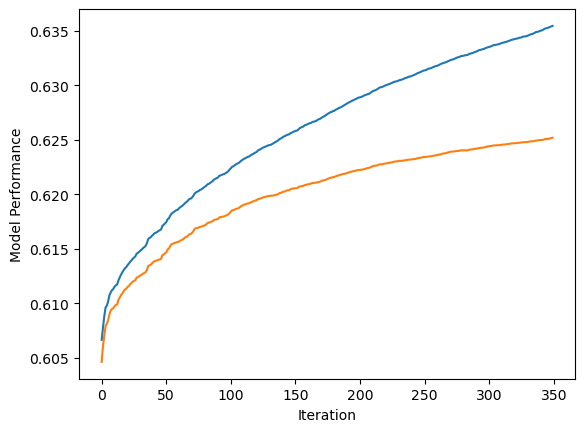

In [22]:
# evaluate model
history=xgb_dask_clf['history']

plt.plot(history['train']['auc'], label='Train Score (AUC)')
plt.plot(history['valid']['auc'], label='Test Score (AUC)')

plt.xlabel('Iteration')
plt.ylabel('Model Performance')
plt.show()

In [23]:
# predict
start=time.time()
prediction_test=xgboost.dask.predict(client, xgb_dask_clf, dtest)
elapsed_time=time.time()-start

print(f'Accuracy score for val set: {round(float(accuracy_score(y_test, prediction_test>0.5))*100, 2)}%')

throughput=round(len(X_test)/elapsed_time, 2)
print(f'Throughput is: {throughput} per seconds. ')

Accuracy score for val set: 61.29%
Throughput is: 1720818.82 per seconds. 


/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a cudf object before performing the operation.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a cudf object before performing the operation.
  warnings.warn(
/opt/conda/envs/rapids/lib/python3.9/site-packages/cudf/core/single_column_frame.py:345: FutureWarning: Binary operations between host objects such as <class 'numpy.ndarray'> and <class 'cudf.core.series.Series'> are deprecated and will be removed in a future release. Please convert it to a 

<a name='s2-3.3'></a>
### Save Model ###

XGBoost has two distinct parts: 
1. The model consisting of trees
2. Hyperparameters and configurations used for building the model

Generally, we are only concerned with the model (#1), but sometimes the model's training configuration (#2) such as the objective function can also be useful if the model needs to be trained further. 

In [24]:
# save model
xgb_dask_clf['booster'].save_model('model.json')

We can use instantiate `xgboost.Booster()`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster) and use `.load_model()`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.load_model) to load the model configuration. 

In [25]:
# load model
xgb_dask_clf=xgboost.Booster()
xgb_dask_clf.load_model('model.json')

<a name='s2-4'></a>
## Feature Importances ##
Ensemble trees provide  estimates of feature importance from a trained model. Users can get the scores with `xgboost.Booster.get_score()`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score). Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the trees within the model. The more frequently a feature is used to split the data, the higher its relative importance. The importance types are defined as: 
* `weight` (default) - the number of times a feature is used to split the data across all trees. This is equivalent to `xgboost.Booster.get_fscore()`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.Booster.get_score)
* `gain` - the average gain across all splits the feature is used in
* `cover` - the average coverage across all splits the feature is used in
* `total_gain` - the total gain across all splits the feature is used in
* `total_cover` - the total coverage across all splits the feature is used in

We plot the scores manually. Alternatively, the built-in `xgboost.plot_importance()`[[doc]](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.plot_importance) can be used. 

In [26]:
# get scores
scores=xgb_dask_clf.get_score()
scores=sorted(scores.items(), key=lambda x:x[1], reverse=True)
scores

[('relative_price_product', 2515.0),
 ('price', 2441.0),
 ('relative_price_category', 2381.0),
 ('ts_minute', 1843.0),
 ('ts_hour', 1772.0),
 ('TE_brand_target', 1733.0),
 ('ts_weekday', 1095.0),
 ('brand', 1021.0),
 ('brand_target_sum', 984.0),
 ('TE_cat_1_target', 803.0),
 ('TE_cat_2_target', 746.0),
 ('cat_1', 615.0),
 ('TE_cat_0_target', 594.0),
 ('cat_2', 461.0),
 ('brand_count', 457.0),
 ('cat_0', 351.0),
 ('cat_2_target_sum', 296.0),
 ('cat_1_target_sum', 282.0),
 ('TE_cat_3_target', 161.0),
 ('cat_0_target_sum', 148.0),
 ('cat_2_count', 89.0),
 ('cat_1_count', 48.0),
 ('cat_0_count', 28.0),
 ('cat_3', 8.0),
 ('cat_3_target_sum', 3.0)]

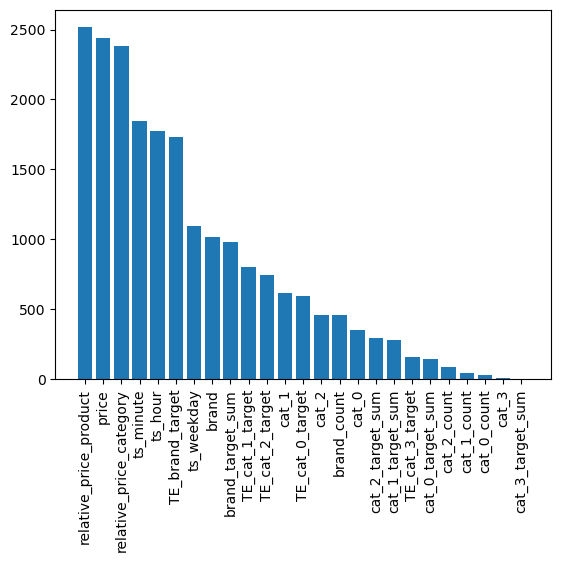

In [27]:
# plot feature importances
plt.bar(x=[feat for feat, score in scores], height=[score for feat, score in scores])
plt.xticks(rotation=90)
plt.show()

In [28]:
# clean GPU memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

{'status': 'ok', 'restart': False}

**Well Done!** Let's move to the [next notebook](2_03_model_tuning.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>